In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scipy
from IPython import display
import seaborn as sns
from scipy import signal
import warnings
from tqdm import tqdm
from sklearn.decomposition import PCA, KernelPCA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import in_d
from sklearn.preprocessing import MinMaxScaler
import multiprocessing as mp
## MODELS ##################
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression, ElasticNetCV, BayesianRidge, SGDRegressor, LogisticRegression
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.svm import SVR, SVC
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score, cross_validate,ShuffleSplit
from tqdm import tqdm, trange
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
print("Number of processors: ", mp.cpu_count())

warnings.filterwarnings('ignore')
%matplotlib inline

Number of processors:  12


## Data preprocessing
Two filed describes our data. The first data isfeatures, `Features2_reduced.csv`, that is described by feature names `Text.txt`. The second part is RA disease progression information `Target2.csv`. 

In [2]:
file = open('results_0702/Text.txt') ##### Feature names
feat_names = []
original_feat_names = []
for i in file:
    if 'bc2+' in i:
        feat_names.append(i.replace('bc2+', '')[:-1] + 'bc2+') ##### Replace the name bc2 -> smth else
    else:
        feat_names.append(i[:-1])
    original_feat_names.append(i[:-1])
feat_names[6], original_feat_names[6]


('CD4+GATA3+Ki67+bc2+', 'CD4+GATA3+bc2+Ki67+')

In [3]:
X_raw = pd.read_csv('results_0702/Features2_reduced.csv', header = None)## The data 
y = pd.read_csv('results_0702/Target2.csv', header = None)              ## The target
scl = MinMaxScaler()
X = pd.DataFrame(scl.fit_transform(X_raw))
target = y[0].map({k : i for i,k in enumerate(y[0].unique())})
X.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0.106726,0.000000,0.158966,0.089011,0.440559,0.863158,0.048559,0.422442,0.15248,0.054833,...,0.059096,0.065147,0.775824,0.078476,0.848571,0.852174,0.995960,0.530271,0.113614,0.0
1,0.194760,0.008633,0.851724,0.039011,0.362238,0.884211,0.034258,0.368537,0.18880,0.283211,...,0.070205,0.063830,0.817582,0.103810,0.871429,0.673913,0.994949,0.604384,0.151807,0.0
2,0.177185,0.018297,0.393103,0.111676,0.475524,0.791813,0.073853,0.491749,0.15104,0.159412,...,0.070205,0.108409,0.786813,0.137143,0.890000,0.782609,0.976768,0.518789,0.208434,0.0
3,0.100815,0.118670,0.063448,0.364011,0.633566,0.918129,0.202775,0.526953,0.10608,0.077445,...,0.082703,0.024113,0.857143,0.070286,0.805714,0.747826,0.995960,0.606472,0.181928,0.0
4,0.105448,0.061075,0.073448,0.660714,0.690909,0.486550,0.299893,0.515952,0.04160,0.053137,...,0.105848,0.066971,0.958242,0.127429,0.978571,0.739130,0.980808,0.432150,0.197590,0.0


In [4]:
input_to_target = {k : i for i,k in enumerate(y[0].unique())}
target_to_input = {input_to_target[key] : key for key in input_to_target }
 

### Data analysis
The code performs the analysis of data set, that includes the best feature selection for different ML algorithms.

In [5]:
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression, ElasticNetCV, BayesianRidge, SGDRegressor
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score, cross_validate,ShuffleSplit
from tqdm import tqdm, trange

#### ML regressors to show the best performance


regressors = {
#     'Lasso' : LassoCV(random_state = 1),

    'GradientBoostingRegressor1' : LGBMRegressor(num_leaves=31, max_depth=- 1, learning_rate=0.1, n_estimators=200, random_state = 1),
    'GradientBoostingRegressor2' : LGBMRegressor(num_leaves=31, max_depth=- 1, learning_rate=0.1, n_estimators=100, random_state = 1),
    'GradientBoostingRegressor3' : LGBMRegressor(num_leaves=31, max_depth=- 1, learning_rate=0.1, n_estimators=50,  random_state = 1),
    'GradientBoostingRegressor3' : LGBMRegressor(num_leaves=31, max_depth=- 1, learning_rate=0.1, n_estimators=50,  random_state = 1),
    'GradientBoostingRegressor5' : LGBMRegressor(num_leaves=62,   learning_rate=0.1, n_estimators=200, random_state = 1),
    'GradientBoostingRegressor6' : LGBMRegressor(num_leaves=62,   learning_rate=0.1, n_estimators=100, random_state = 1),
    'GradientBoostingRegressor7' : LGBMRegressor(num_leaves=62,   learning_rate=0.1, n_estimators=50,  random_state = 1),
    'GradientBoostingRegressor8' : LGBMRegressor(num_leaves=62,   learning_rate=0.01, n_estimators=400, random_state = 1),
    'GradientBoostingRegressor9' : LGBMRegressor(num_leaves=62,   learning_rate=0.01, n_estimators=300, random_state = 1),
    'GradientBoostingRegressor10' : LGBMRegressor(num_leaves=62,   learning_rate=0.05, n_estimators=150,  random_state = 1),
    'GradientBoostingRegressor11' : LGBMRegressor(num_leaves=62,   learning_rate=0.05, n_estimators=400, random_state = 1),
    'GradientBoostingRegressor12' : LGBMRegressor(num_leaves=62,   learning_rate=0.05, n_estimators=300, random_state = 1),
    'GradientBoostingRegressor13' : LGBMRegressor(num_leaves=62,   learning_rate=0.01, n_estimators=450,  random_state = 1),

    'GradientBoostingRegressor14' : GradientBoostingRegressor(random_state = 1),


    'Ridge' : RidgeCV(),
    'LinearRegression' : LinearRegression(),
    'ElasticNet' : ElasticNetCV(),

    'SGDl2': SGDRegressor(loss='squared_loss', penalty='l2', random_state = 1),
    'SGDl1': SGDRegressor(loss='squared_loss', penalty='l1', random_state = 1),

    'RandomForestRegressor1' : RandomForestRegressor(n_estimators=50, random_state = 1, n_jobs = -1),
    'RandomForestRegressor2' : RandomForestRegressor(n_estimators=100, random_state = 1, n_jobs = -1),
    'RandomForestRegressor3' : RandomForestRegressor(n_estimators=150, random_state = 1, n_jobs = -1),
    'RandomForestRegressor4' : RandomForestRegressor(n_estimators=50, max_depth=5, random_state = 1, n_jobs = -1),
    'RandomForestRegressor5' : RandomForestRegressor(n_estimators=100, max_depth=5, random_state = 1, n_jobs = -1),
    'RandomForestRegressor6' : RandomForestRegressor(n_estimators=150, max_depth=5, random_state = 1, n_jobs = -1),
    'RandomForestRegressor7' : RandomForestRegressor(n_estimators=50,  max_depth=10, random_state = 1, n_jobs = -1),
    'RandomForestRegressor8' : RandomForestRegressor(n_estimators=100, max_depth=10, random_state = 1, n_jobs = -1),
    'RandomForestRegressor9' : RandomForestRegressor(n_estimators=150, max_depth=10, random_state = 1, n_jobs = -1),
    'RandomForestRegressor10' : RandomForestRegressor(n_estimators=250,  random_state = 1, n_jobs = -1),
    'RandomForestRegressor11' : RandomForestRegressor(n_estimators=200, random_state = 1, n_jobs = -1),
    'RandomForestRegressor12' : RandomForestRegressor(n_estimators=400, random_state = 1, n_jobs = -1),

    'RandomForestRegressor13' : RandomForestRegressor(n_estimators=450, random_state = 1, n_jobs = -1),
    'RandomForestRegressor14' : RandomForestRegressor(n_estimators=500, random_state = 1, n_jobs = -1),
    'RandomForestRegressor15' : RandomForestRegressor(n_estimators=150, random_state = 1, n_jobs = -1),
    'RandomForestRegressor16' : RandomForestRegressor(n_estimators=200,  random_state = 1, n_jobs = -1),
    'RandomForestRegressor17' : RandomForestRegressor(n_estimators=300, random_state = 1, n_jobs = -1),
    'RandomForestRegressor18' : RandomForestRegressor(n_estimators=350, random_state = 1, n_jobs = -1),

    'SVRpoly' : SVR(kernel = 'poly'),
    'SVRlinear' : SVR(kernel='linear'),
    'SVRrbf': SVR(),


    'SVRrbf': SVR(C = 5),
    'SVRpoly2' : SVR(kernel = 'poly', C = 5),
    'SVRlinear2' : SVR(kernel='linear', C = 5),

    'SVRrbf': SVR(C = 10),
    'SVRpoly3' : SVR(kernel = 'poly', C = 10),
    'SVRlinear3' : SVR(kernel='linear', C = 10) 
}



In [6]:
from sklearn.model_selection import KFold, LeaveOneGroupOut
kf = KFold(n_splits=5, shuffle=True, random_state=0)

kf.get_n_splits(X)

5

PMKL or TKL has been tested in Matlab, so we need to use the same CV.

In [7]:
Brendon_indexes = scipy.io.loadmat('results_0702/indexCV.mat')['indexCV'][:, 0].astype(np.int32)
logo = LeaveOneGroupOut() 
logo.get_n_splits(X, y=None, groups = Brendon_indexes)
Brendon_split = []
for train_index, test_index in logo.split(X, y=None, groups = Brendon_indexes):
    Brendon_split.append((train_index, test_index))


In [8]:
# features = pd.read_csv('C:/Users/alexandr/Desktop/courses/research/ml/matlab/chosen_keys.csv')
# features.head()
rf    = [np.argwhere(name == np.array(original_feat_names))[0,0] for name in list(pd.read_csv('results_0702/RF.csv')['Feature'][:11])]
mi    = [np.argwhere(name == np.array(original_feat_names))[0,0] for name in list(pd.read_csv('results_0702/MI.csv')['Feature'][:11])]
ANOVA = [np.argwhere(name == np.array(original_feat_names))[0,0] for name in list(pd.read_csv('results_0702/ANOVA.csv')['Feature'][:11])]
PCA   = [np.argwhere(name == np.array(original_feat_names))[0,0] for name in list(pd.read_csv('results_0702/PCA.csv')['Feature'][:11])]

FS_method = {
    'RF' : np.array(rf),
    'MI' : np.array(mi),
    'ANOVA' : np.array(ANOVA),
    'PCA' : np.array(PCA)[np.array(PCA) != 42] 
}
FS_method

{'RF': array([37, 32,  9, 29, 34, 33, 36,  8, 15, 13, 21], dtype=int64),
 'MI': array([ 9, 37, 21, 34, 29, 24, 19, 13, 39, 18, 11], dtype=int64),
 'ANOVA': array([34, 37, 30, 38, 33, 39, 29, 21, 36,  9, 12], dtype=int64),
 'PCA': array([41, 22, 16,  5, 30,  1, 38, 36,  6,  0], dtype=int64)}

In [9]:
#################### Uncomment for computational results ################################


####### Computational of feature selection techniques based on other methods (RA, MI, ANOVA, PCA)

# target = y
# train_mse = {}
# test_mse  = {}
# to_iter = []
# for reg in regressors:
#     for FS in FS_method:
#             to_iter.append((reg, FS))
# to_iter = np.random.permutation(to_iter)
# len(to_iter)
# # test_df  = pd.read_csv('DS_FS_and_ML_test.csv' , index_col= 0)
# # train_df = pd.read_csv('DS_FS_and_ML_train.csv', index_col= 0)

# for iteration in to_iter:
#     name_r = iteration[0]
#     name_f = iteration[1]
#     train_mse[name_f +  ' ' + name_r] = []
#     test_mse[name_f +  ' ' + name_r] = []

# for iteration in tqdm(to_iter):
#     name_r = iteration[0]
#     name_f = iteration[1]
# #     k      = int(iteration[2])
# #     if name_r == 'LinearRegression':
# #         pass
# #     else:
# #         continue
    
# #     if name_f == 'PCA':
# #         pass
# #     else:
# #         continue
#     model    = regressors[name_r]
#     features = FS_method[name_f]
#     tr = []
#     te = []
#     for ind ,k in enumerate(range(1, 11)):
# #         if (name_f + ' ' + name_r in test_df.columns) and (ind in test_df.index):
# #             test_mse[name_f + ' ' + name_r].append(test_df[name_f + ' ' + name_r][ind])
# #             train_mse[name_f + ' ' + name_r].append(train_df[name_f + ' ' + name_r][ind])
# #             continue
# #         print(k)
#         for col in range(target.shape[1]):
#             if col in features[np.arange(k)]:
#                 te.append(0)
#                 tr.append(0)
#                 continue
#             y = target[col]
#             scores = cross_validate(model, X[ features[np.arange(k)]], y, cv=Brendon_split,
#                                     scoring = 'neg_root_mean_squared_error', return_train_score = True, n_jobs = -1)
#             te.append(-np.mean( scores['test_score'] )) 
#             tr.append(-np.mean( scores['train_score'] ))
#         train_mse[name_f + ' ' + name_r].append( np.mean(tr))
#         test_mse[name_f +  ' ' + name_r].append( np.mean(te))
# #     break

# #         break
# #     break

# # pd.DataFrame(train_mse).to_csv('IS_FS_and_ML_train.csv')
# # pd.DataFrame(train_mse).to_csv('IS_FS_and_ML_test.csv')

In [10]:

test_mse = pd.read_csv('results_0702/DS_FS_and_ML_test2.csv', index_col= 0)
train_mse = pd.read_csv('results_0702/DS_FS_and_ML_train2.csv', index_col=0)
import scipy.io as sio
TKL_features = sio.loadmat('results_0702/FS1in.mat')['index'] - 1
TKL_error = sio.loadmat('results_0702/FS2error.mat')['errorMin']
test_mse.head()

,ANOVA GradientBoostingRegressor8,RF GradientBoostingRegressor3,ANOVA GradientBoostingRegressor12,ANOVA SGDl2,MI RandomForestRegressor2,RF GradientBoostingRegressor9,ANOVA GradientBoostingRegressor2,MI RandomForestRegressor8,MI SVRlinear2,PCA GradientBoostingRegressor3,...,ANOVA RandomForestRegressor15,RF RandomForestRegressor11,RF SVRlinear3,RF SVRpoly,MI SGDl2,MI RandomForestRegressor4,MI RandomForestRegressor14,ANOVA LinearRegression,ANOVA RandomForestRegressor4,MI SVRpoly3
0,1.455739,1.427138,1.467089,1.424935,1.566518,1.426717,1.467398,1.544909,1.524803,1.427047,...,1.437196,1.514335,1.593041,1.615791,1.374315,1.374363,1.573306,1.428284,1.408050,1.505701
1,1.451523,1.387350,1.471281,1.431314,1.525220,1.388237,1.465503,1.512955,1.498826,1.446262,...,1.451499,1.524679,1.607542,1.643997,1.375709,1.395659,1.526928,1.424930,1.421952,1.591906
2,1.442077,1.351770,1.458696,1.431870,1.507750,1.350447,1.453191,1.499670,1.495104,1.444487,...,1.454260,1.504130,1.554251,1.604877,1.377955,1.412895,1.509495,1.417324,1.437841,1.656464
3,1.443011,1.339459,1.462686,1.432124,1.494919,1.334841,1.455659,1.488907,1.479831,1.451239,...,1.466795,1.474172,1.527926,1.600365,1.377185,1.419594,1.499124,1.414452,1.455571,1.661218
4,1.446462,1.334167,1.465874,1.432112,1.473550,1.327426,1.459722,1.468560,1.467416,1.455818,...,1.473233,1.457733,1.492455,1.583084,1.376860,1.416839,1.480477,1.416973,1.467281,1.691153


In [11]:

# TKL_features_new = sio.loadmat('C:/Users/alexandr/Desktop/python/Immunology/results_0702/FS1in.mat')['index'] - 1
# TKL_error_new = sio.loadmat('C:/Users/alexandr/Desktop/python/Immunology/results_0702/FS2error.mat')['errorMin']

In [12]:
 
chosen_features = {}
the_best_test_mse= {}

chosen_features['SFS TKL'] = list(TKL_features[0,:5])
the_best_test_mse['SFS TKL'] = [TKL_error[0,4]]


for i, name_f in enumerate(FS_method):
    min_acc = 1000
    for j, name_r in enumerate(regressors):
        te = test_mse[name_f + ' ' + name_r]/y.max()[0]
        tr = train_mse[name_f + ' ' + name_r]/y.max()[0] 
        k = np.arange(len(te))+1
        chosen_k = 10 
        acc = te[chosen_k-1]
        
        if acc < min_acc:
            min_acc = acc
            features_per_FSM = FS_method[name_f][:10]
    the_best_test_mse[name_f + ' the best model'] = [min_acc]
    chosen_features[name_f + ' the best model'] = features_per_FSM 

In [14]:
import pickle
# def save_obj(obj, name ):
# with open('IS_SFS.pkl', 'wb') as f:
#     pickle.dump(dct_SFS, f, pickle.HIGHEST_PROTOCOL)
    
with open('results_0702/results_dct_SFS_DS2.pkl', 'rb') as f:
    res = pickle.load(f)
    
dct_SFS = res
# dct_SFS = {}

In [15]:
#################### Uncomment for computational results ################################

####### Computational of SFS feature selection techniques
# import time
# # dct_SFS = {}
# # m_SFSold = oldSFS()
# m_SFS = in_d.SFS()
# for name in regressors:
# #     print(name)
#     if name in dct_SFS:
#         continue

#     initial = time.time() 
#     scores = m_SFS.fit(regressors[name], np.array(X ), np.array(target ),  cv = Brendon_split)

#     i = np.argmin(scores['test'])
#     dct_SFS[name] = scores
#     print(name, 'min mse %.3f' % np.min(scores['test']), ';\t n_features=%d' %i , '; \t time %.1f' % (time.time()-initial))
# #     break
        
#     #     break

In [16]:
 
for i, name_f in enumerate(dct_SFS): 
    te = dct_SFS[name_f]['test'][:-1]/y.max()[0]
    tr = dct_SFS[name_f]['train'][:-1]/y.max()[0] 
    k = np.arange(len(te))+1
    index = np.argmin(te)
    
    chosen_features['SFS ' + name_f] = dct_SFS[ name_f]['set'][:index+1]
    the_best_test_mse['SFS ' + name_f] = [ dct_SFS[name_f]['test'][index]/y.max()[0]] 

In [17]:
linear_models = ['Ridge', 'LinearRegression','ElasticNet']
SVRS = [key for key in dct_SFS if 'SVR' in key]
Trees = [key for key in dct_SFS if 'RandomForestRegressor' in key]
BoostedTrees = [key for key in dct_SFS if 'GradientBoostingRegressor' in key]
TKL = ['TKL']
final_best_err = {}
FINAL_NAMES = ['Linear Model', "SVR", "Random Forest", "Boosted Trees", "PMKL"]
FINAL_GROUPS = [linear_models, SVRS, Trees, BoostedTrees, TKL]
final_best_fea = {}

for common_name, model_names in zip(FINAL_NAMES, FINAL_GROUPS):
    min_acc = 10000
    for model_name in model_names:
        if ('SFS '+ model_name) not in the_best_test_mse:
            continue
        acc = the_best_test_mse['SFS ' + model_name][0]
        fea = chosen_features[  'SFS ' + model_name]
        if acc < min_acc:
            min_acc = acc
            min_feat = fea
    final_best_err['SFS ' + common_name] = [min_acc]
    final_best_fea['SFS ' + common_name] = min_feat

final_best_err['SFS PMKL'] = [0.341985]#Previous results
final_best_err['SFS SVR'] = [0.366617]#Previous results
    
final_best_err['RF']    = [0.383919]#the_best_test_mse['RF the best model']
final_best_err['MI']    = [0.380073]#the_best_test_mse['MI the best model']
final_best_err['ANOVA'] = [0.384205]#the_best_test_mse['ANOVA the best model'] 
final_best_err['PCA']   = [0.400748]#the_best_test_mse['PCA the best model']

final_best_fea['RF']    = chosen_features['RF the best model']
final_best_fea['MI']    = chosen_features['MI the best model']
final_best_fea['ANOVA'] = chosen_features['ANOVA the best model']
final_best_fea['PCA']   = chosen_features['PCA the best model']

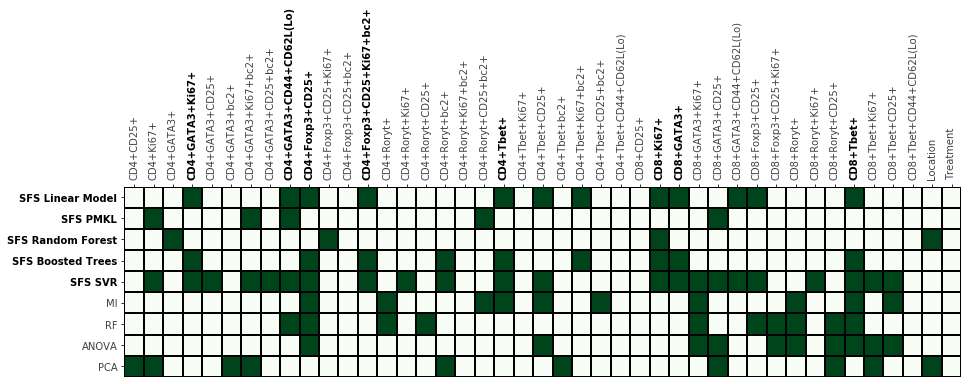

In [19]:
import datetime
today = datetime.date.today()
RES_MSE = pd.DataFrame(final_best_err, index = None).T.sort_values(by = 0, ascending = False) 
# all_feat= set()
# for col in final_best_fea:
#     all_feat = all_feat.union(final_best_fea[col])
all_feat = range(43)
final_table = {}
for col in final_best_fea:
    final_table[col] = {}
    for ind in all_feat:
        if ind in final_best_fea[col]:
            final_table[col][ind] = 1
        else:
            final_table[col][ind] = 0
 
    
    # sum(SIZE)
answer = pd.DataFrame(final_table).T.rename(columns = {i : name  for i, name in enumerate(feat_names)}).T[RES_MSE.index[::-1]].T
plt.figure(figsize=(15,3.5))
pal = sns.color_palette("viridis", as_cmap=True)


ax = sns.heatmap(

    (answer-0.5)*2, 
    vmin=-1, vmax=1, center=0,
    cmap='Greens', linewidths=1, linecolor='black', cbar = False
#     palette = pal
#     square=True
)
# 
# ax2 = ax.twinx()
# ax2 = ax2.set_xlabel(answer.columns)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
#     horizontalalignment='right'
)
ax.tick_params(top=True, bottom=False,
               labeltop=True, labelbottom=False)

for (marker, ticklbl) in zip(list(answer.iloc[:5].sum() > 2), ax.xaxis.get_ticklabels()):
#     ticklbl.set_color('red' if marker else 'black')
#     ticklbl.set_backgroundcolor('yellow' if marker else 'white')
#     ticklbl.set_fontstyle('italic'  if marker else 'normal')
    ticklbl.set_fontweight(weight='bold' if marker else 'normal')
#     ticklbl.set_fontsize(12 if marker else 10 )
    ticklbl.set_alpha(1 if marker else 0.75)
    
    
    
for (marker, ticklbl) in zip([1, 1, 1, 1, 1, 0, 0, 0, 0], ax.yaxis.get_ticklabels()):
#     ticklbl.set_color('red' if marker else 'black')
#     ticklbl.set_backgroundcolor('#FFFFF' if marker else 'white')
#     ticklbl.set_fontstyle('italic'  if marker else 'normal')
    ticklbl.set_fontweight( 'bold' if marker else 'normal')
#     ticklbl.set_fontsize(12 if marker else 10 )
    ticklbl.set_alpha(1 if marker else 0.75)
# ax.text(0.1, -0.1,'asd',verticalalignment='bottom',horizontalalignment='right',transform=ax.transAxes,color='green', fontsize=20)

# ax = ax.set_xlabel(second_label)
# plt.grid()
plt.savefig('DS_dotplot_summary_' +in_d.today_date()+'.png', dpi = 300, bbox_inches='tight')